## Economic Effects of ASEAN Integration on Household Living Standards

### Abstract
The importance to study integration effects on individual Southeast Asian countries is increasing since the establishment of ASEAN economic community (AEC) in 2007, which aims to build a single market and more integrated development cooperation. The reality of limited data among these countries and needs to analyze in the multi-level structure create an ideal condition for the usage of hierarchical Bayesian model. We demonstrate the analysis of impact of ASEAN integration on individual countries and intermediate effects from domestic infrastructures using **hierarchical Bayesian model with the non-cetered parameterization**. The results verify previous research showing “the rich get richer and the poor get poorer” during the integration process. More advanced countries in the region benefit from more connected trade relationships and the inflow of migrant workers. In contrast, less developed countries suffer from the outflow of capitals and brain drain. However, we also find promising evidence that governments can improve living standards through developing information communication technology infrastructures, which can create additional positive contribution toward living standards during integration.

### Load Data

In [1]:
import pystan
import pickle
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as statmod
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from math import pi

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5000)
df = pd.read_excel("C:\\Users\\steve\\Google Drive\\Research\\data\\Succinct Version_V42.xlsx")
df.shape

(70, 19)

In [3]:
df

Country  Country_Code  Year  Food_Share  Intercept  \
0      Cambodia             0  2013   46.684951          1   
1      Cambodia             0  2014   44.007176          1   
2      Cambodia             0  2015   43.600295          1   
3      Cambodia             0  2016   42.790198          1   
4      Cambodia             0  2017   42.507479          1   
5      Cambodia             0  2018   42.332431          1   
6     Indonesia             1  2010   33.400000          1   
7     Indonesia             1  2011   33.660000          1   
8     Indonesia             1  2012   32.642000          1   
9     Indonesia             1  2013   32.117332          1   
10    Indonesia             1  2014   31.437340          1   
11    Indonesia             1  2015   31.883520          1   
12    Indonesia             1  2016   31.629787          1   
13    Indonesia             1  2017   31.865202          1   
14    Indonesia             1  2018   31.747117          1   
15         Laos             2  2013   50.105585          1   
16         Laos             2  2014   50.047406          1   
17         Laos             2  2015   50.006328          1   
18         Laos             2  2016   49.946369          1   
19     Malaysia             3  2010   20.100000          1   
20     Malaysia             3  2011   20.703000          1   
21     Malaysia             3  2012   20.271000          1   
22     Malaysia             3  2013   20.547570          1   
23     Malaysia             3  2014   20.567793          1   
24     Malaysia             3  2015   21.014249          1   
25     Malaysia             3  2016   21.521291          1   
26     Malaysia             3  2017   21.508360          1   
27     Malaysia             3  2018   21.526559          1   
28      Myanmar             4  2013   58.742066          1   
29      Myanmar             4  2014   57.952299          1   
30      Myanmar             4  2015   57.237023          1   
31      Myanmar             4  2016   56.587022          1   
32      Myanmar             4  2017   56.315925          1   
33      Myanmar             4  2018   56.107237          1   
34  Philippines             5  2010   41.500000          1   
35  Philippines             5  2011   42.807000          1   
36  Philippines             5  2012   42.657000          1   
37  Philippines             5  2013   42.566201          1   
38  Philippines             5  2014   42.237185          1   
39  Philippines             5  2015   42.124857          1   
40  Philippines             5  2016   42.150067          1   
41  Philippines             5  2017   42.140591          1   
42  Philippines             5  2018   41.973731          1   
43    Singapore             6  2010    7.500000          1   
44    Singapore             6  2011    6.754000          1   
45    Singapore             6  2012    7.156000          1   
46    Singapore             6  2013    7.222209          1   
47    Singapore             6  2014    7.111882          1   
48    Singapore             6  2015    7.006894          1   
49    Singapore             6  2016    6.883857          1   
50    Singapore             6  2017    6.870015          1   
51    Singapore             6  2018    6.861152          1   
52     Thailand             7  2010   31.100000          1   
53     Thailand             7  2011   26.676000          1   
54     Thailand             7  2012   25.286000          1   
55     Thailand             7  2013   24.717299          1   
56     Thailand             7  2014   25.054812          1   
57     Thailand             7  2015   24.608219          1   
58     Thailand             7  2016   24.407830          1   
59     Thailand             7  2017   24.328350          1   
60     Thailand             7  2018   24.252953          1   
61      Vietnam             8  2010   36.600000          1   
62      Vietnam             8  2011   36.202000          1   
63      Vietnam             8  2012   38

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


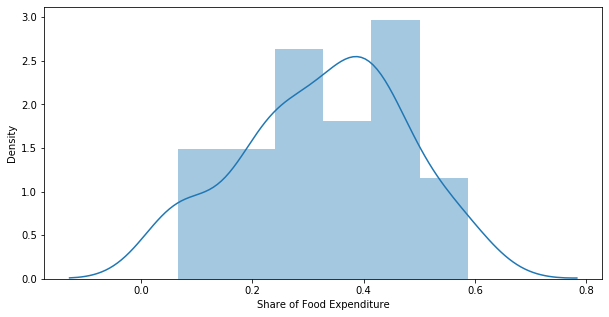

In [4]:
f, ax = plt.subplots(figsize=(10, 5))
s = sns.distplot(df.Food_Share/100)
s.set(xlabel='Share of Food Expenditure')
s.set(ylabel='Density')
plt.show()

### Non-Centered Parameterization Model code

In [5]:
nonCenter_model = """
data {
  int<lower=0> I;           # number of covariate in lower level model
  int<lower=0> J;           # number of covariate in upper level model  
  int<lower=0> N;           # number of observation
  int<lower=0> K;           # number of country
  int<lower=1,upper=K> country[N];
  matrix[K, J] z;           # upper level model的Z的觀察值
  matrix[N, I] x;           # lower level model的X的觀察值
  vector[N] y;              # response variable的觀察值
} 
parameters {
  matrix[J, I] Gamma;       # upper level model的斜率
  matrix[K, I] Delta;       # upper level model的截距
  corr_matrix[I] Omega;     # upper level model correlation matrix (可加可不加，不加的時候transformed那裡的quad_form_diag那項要拿掉，留下Delta[k,]就好)
  vector<lower = 0>[I] tau; # upper level model scale parameters (可加可不加，不加的時候transformed那裡的quad_form_diag那項要拿掉，留下Delta[k,]就好)
  real<lower=0> sigma;      # Variance of the lower level model
} 
transformed parameters {
  matrix[K, I] Beta;        # lower level model的斜率
  for (k in 1:K) {    
    Beta[k,] = z[k,] * Gamma + Delta[k,] * quad_form_diag(Omega,tau);
  }
}
model {
  // Hyperpriors
  for (j in 1:J) {
    Gamma[j,] ~ normal(0, 5);
  }
  Omega ~ lkj_corr(2);
  tau ~ normal(0, 5);       
  sigma ~ gamma(0.01, 0.01);

  // Non-centered population model and likelihood.
  for (k in 1:K) {
    Delta[k,] ~ normal(0, 1); # 每個國家在upper level上都有自己的variation，用standard normal distribution捕捉
  }

  for (n in 1:N) {
    y[n] ~ normal(x[n,] * Beta[country[n],]', sigma);
  }
}
"""

### Train the model

In [6]:
nonCenter_data = {'N': df.shape[0],
                  'I': 5,
                  'J': 4,
                  'K': len(df.Country.unique()),
                  'country': df.Country_Code.values +1, # Stan counts starting at 1
                  'x': np.array(df.iloc[:, 4:9]),
                  'z': np.array([list(df[df['Country_Code']==country_code].iloc[:,15:].mean()) for country_code in range(0,9)]), #將各個國家upper level在各個指標上的data各自平均，成為一個9x4的矩陣
                  'y': df.Food_Share.values}

nonCenter_fit = pystan.stan(model_code=nonCenter_model, data=nonCenter_data, iter=5000, chains=4, control=dict(adapt_delta=0.99,max_treedepth=15))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52a1a96ad82ec2618acad3795040fce5 NOW.


### Estimation Results 

In [7]:
print(nonCenter_fit)

Inference for Stan model: anon_model_52a1a96ad82ec2618acad3795040fce5.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Gamma[1,1]  -0.26    0.03   4.97  -9.98  -3.58  -0.25   3.09   9.48  20657    1.0
Gamma[2,1]   7.75    0.05   3.16   0.94   5.82   7.93   9.84  13.47   4654    1.0
Gamma[3,1]   5.44    0.05   5.07  -4.39   1.96    5.5   8.87  15.37   9523    1.0
Gamma[4,1]  -1.16    0.02   0.91  -2.76  -1.78  -1.23  -0.62   0.84   3512    1.0
Gamma[1,2]  -0.45    0.03   4.93  -9.98  -3.75  -0.47   2.86    9.2  22964    1.0
Gamma[2,2]  -2.12    0.06   4.37 -10.55  -5.08  -2.17   0.77   6.56   6208    1.0
Gamma[3,2]  -0.27    0.04   4.91   -9.8  -3.61  -0.21   3.09   9.22  16709    1.0
Gamma[4,2]   0.07    0.02   1.12   -2.2  -0.65   0.09   0.81   2.25   5519    1.0
Gamma[1,3]  -0.35    0.04   5.06 -10.18  -3.74  -0.33   2.99   9.62  196

### Results Evaluations
<font size="4">**1. Correlation between covariates of upper-level and lower-level models**</font>

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\numeric_utils.py:127: RuntimeWarning: invalid value encountered in sqrt
  std_de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA65A44F98>,
      dtype=object)

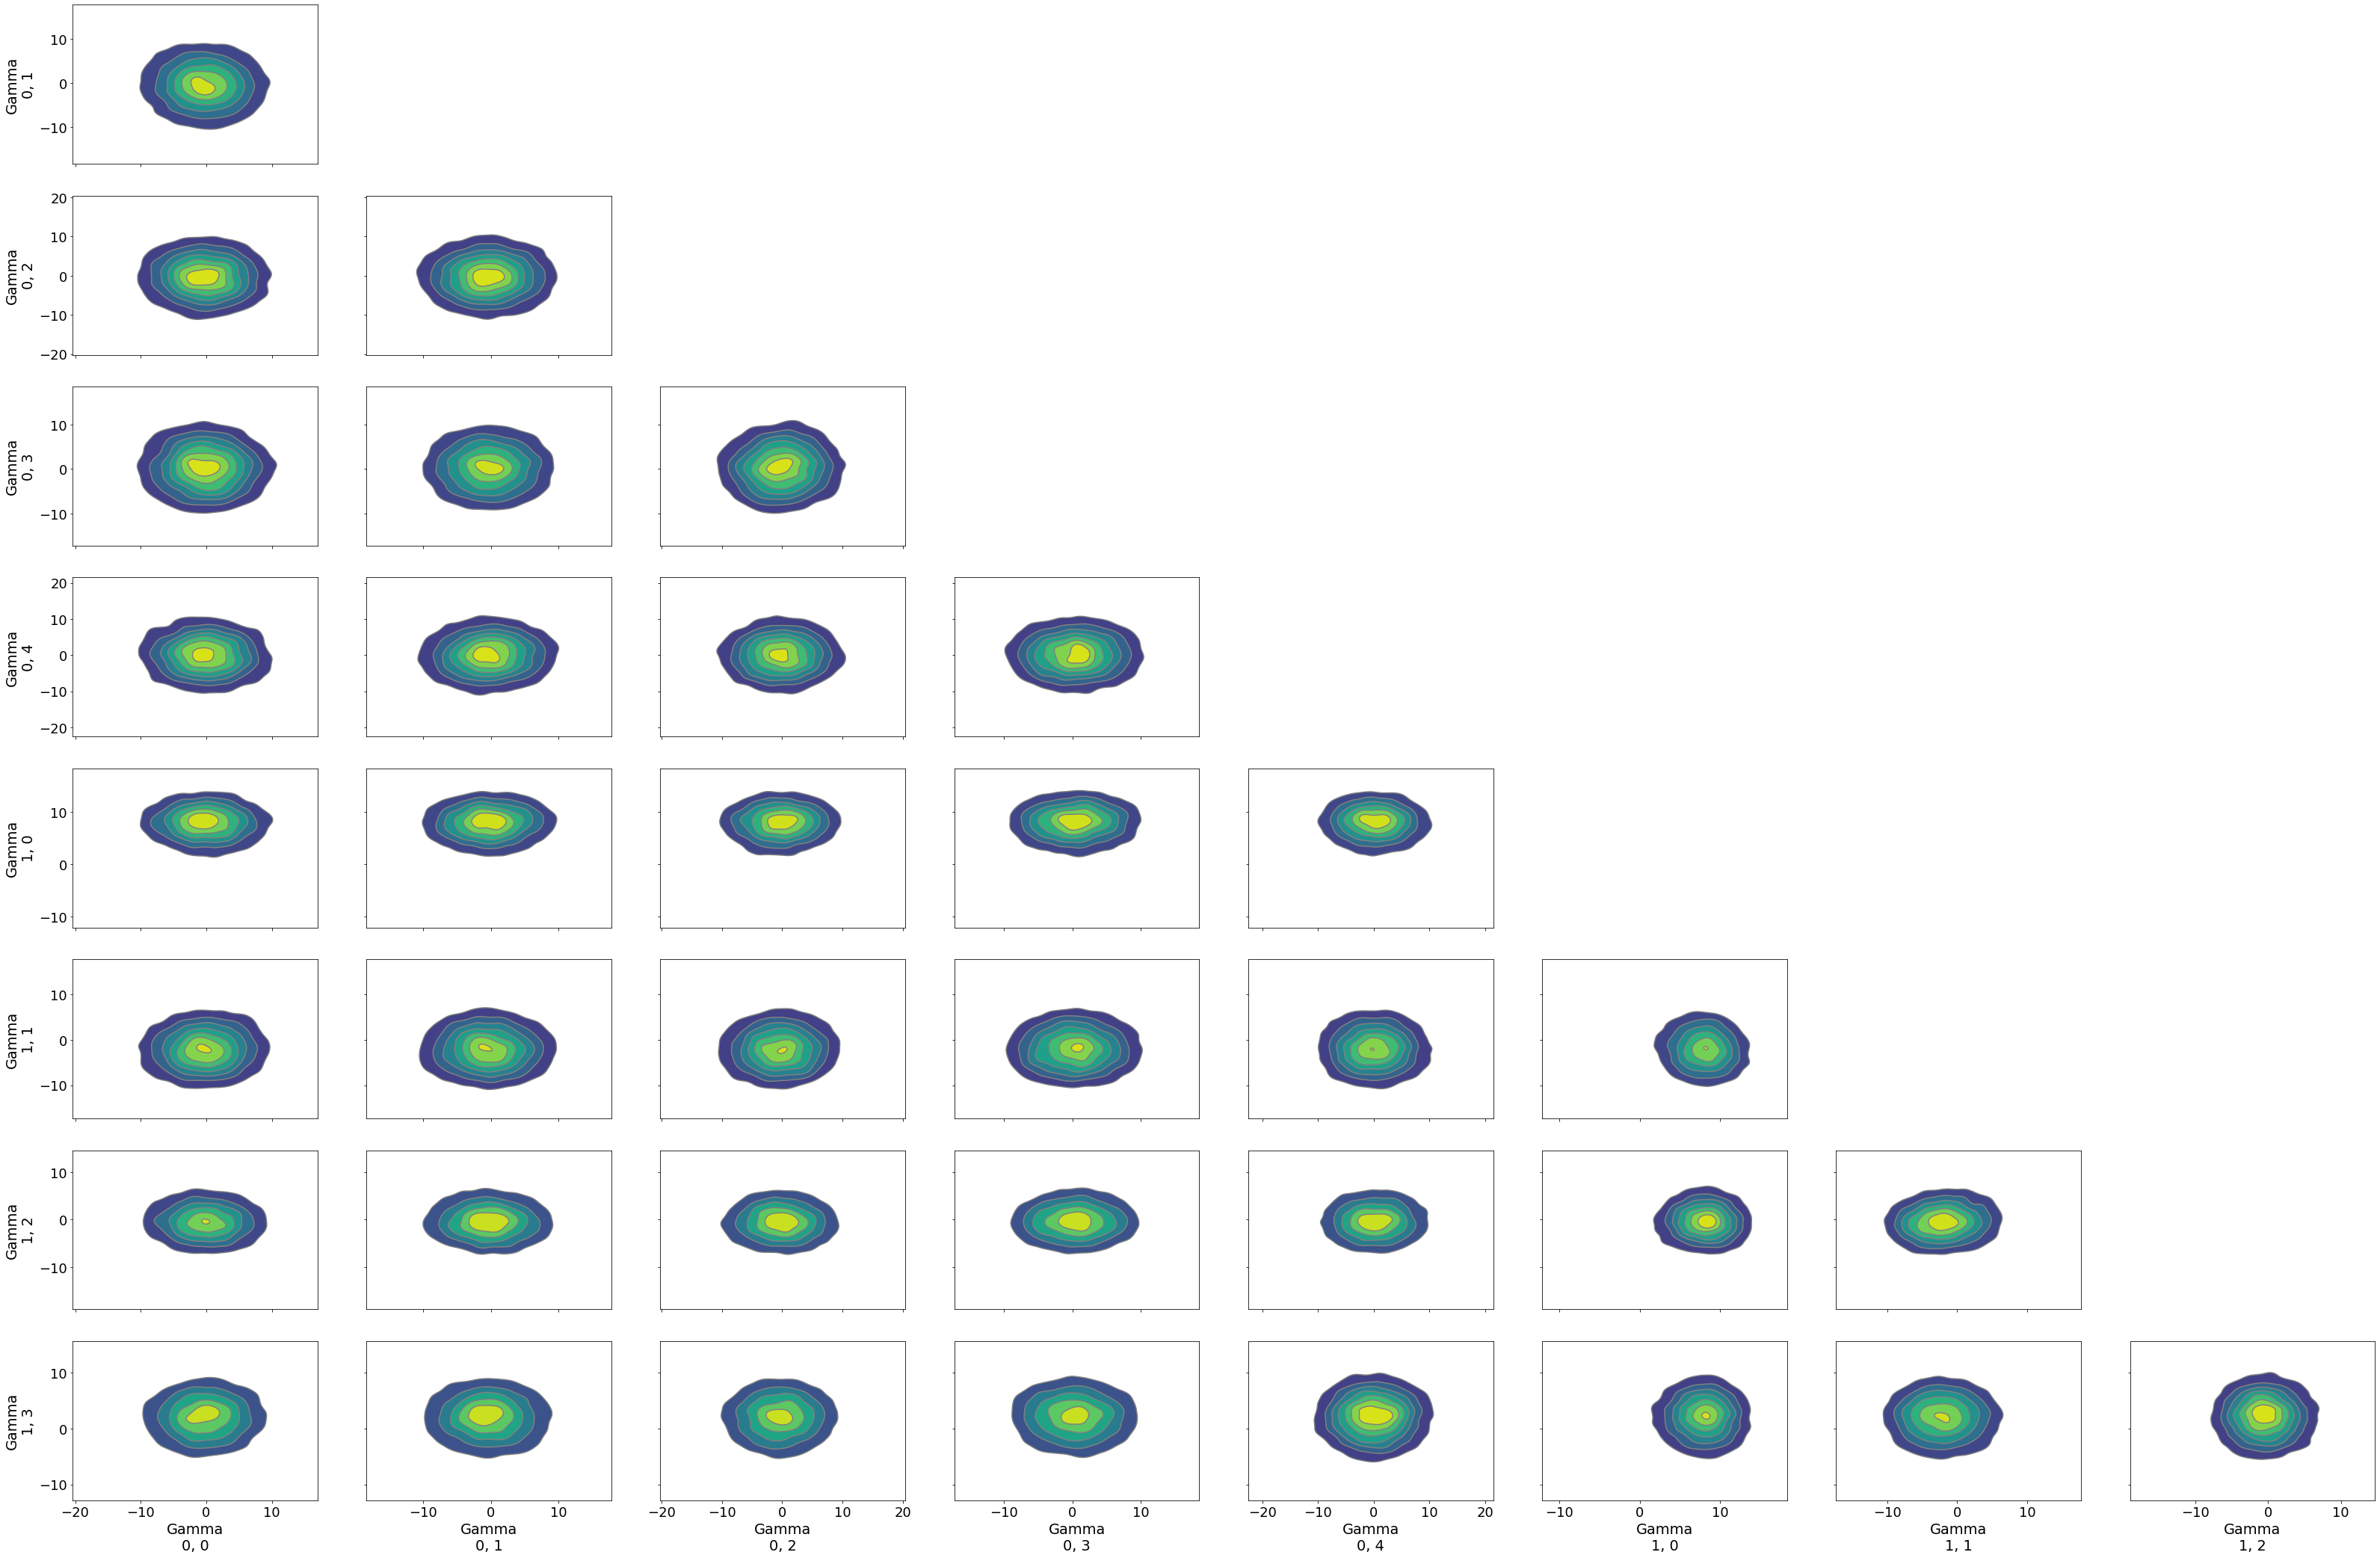

In [8]:
az.plot_pair(nonCenter_fit,
            var_names=["Gamma", "Beta"],
            kind='kde',
            divergences=True,
            textsize=18)

<font size="4">**2. Convergence of estimation results**</font>

<font size="4">Gamma (Upper-level covariates)</font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA64B69BE0>,
      dtype=object)

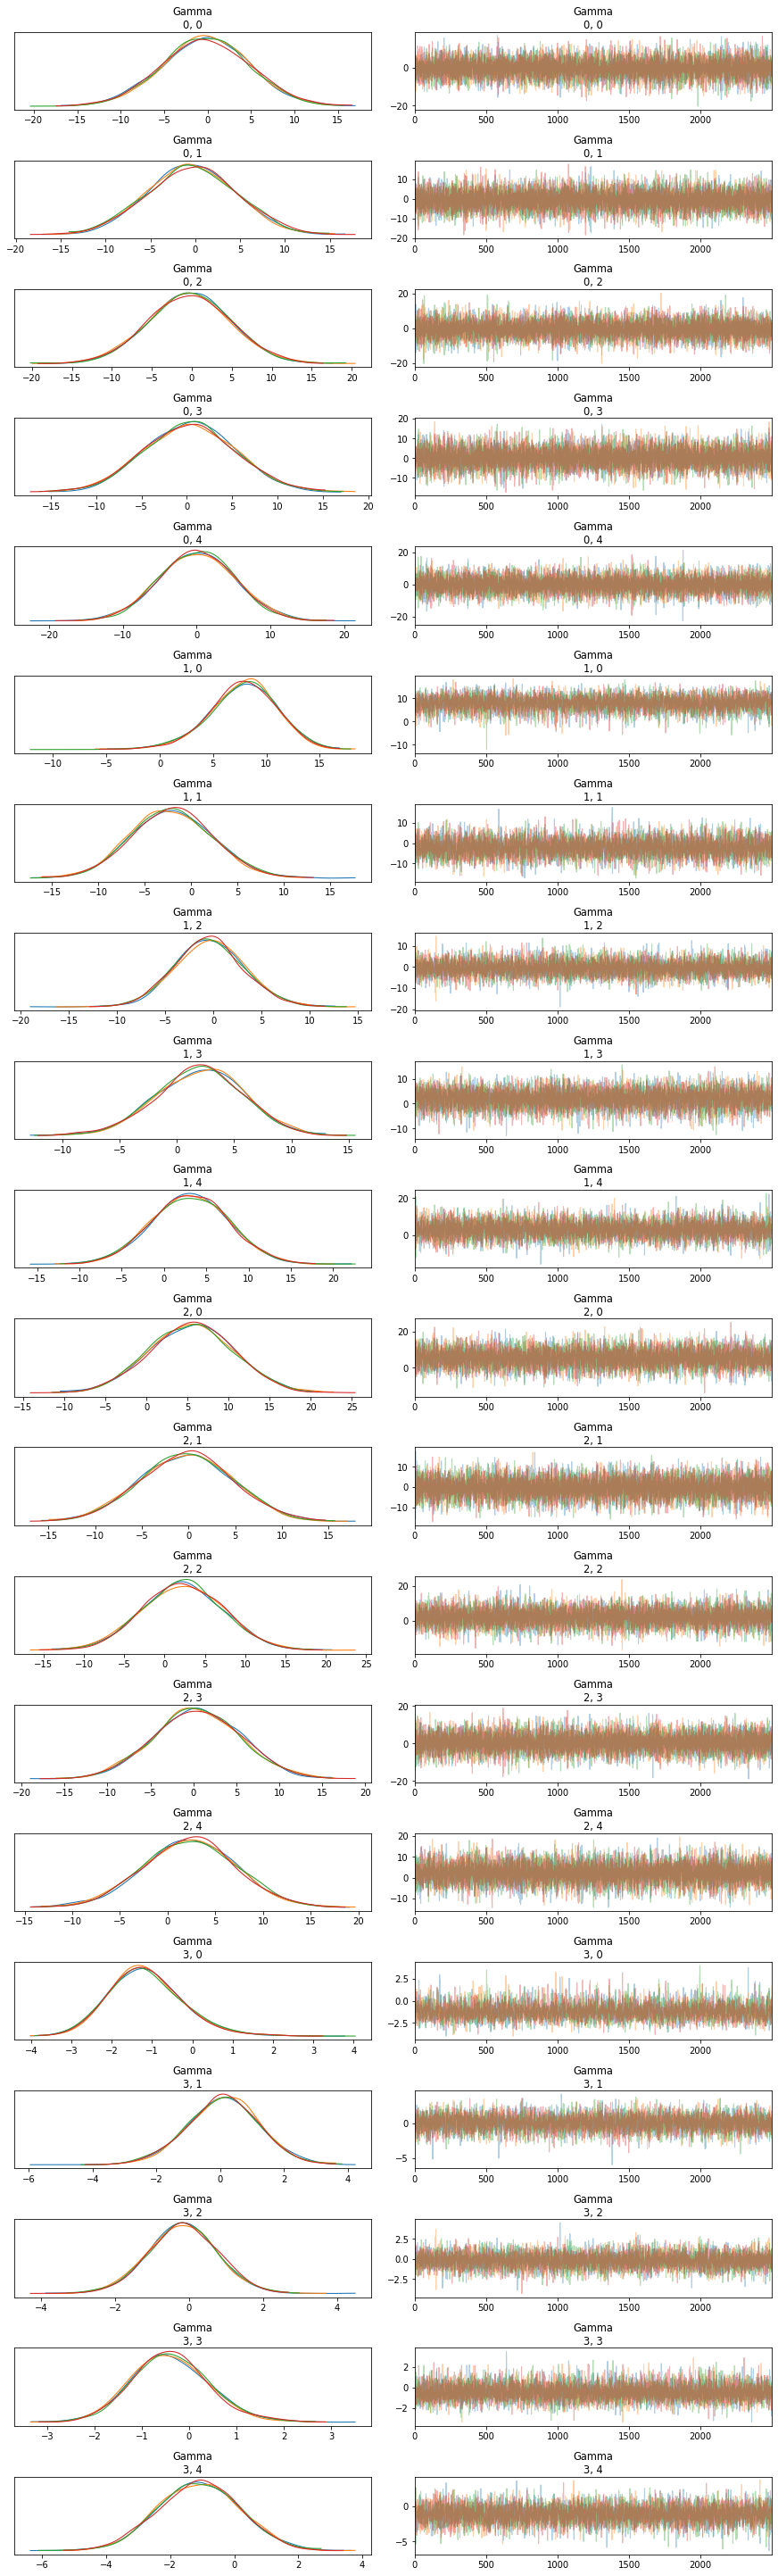

In [9]:
az.plot_trace(nonCenter_fit,var_names=["Gamma"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA67978278>,
      dtype=object)

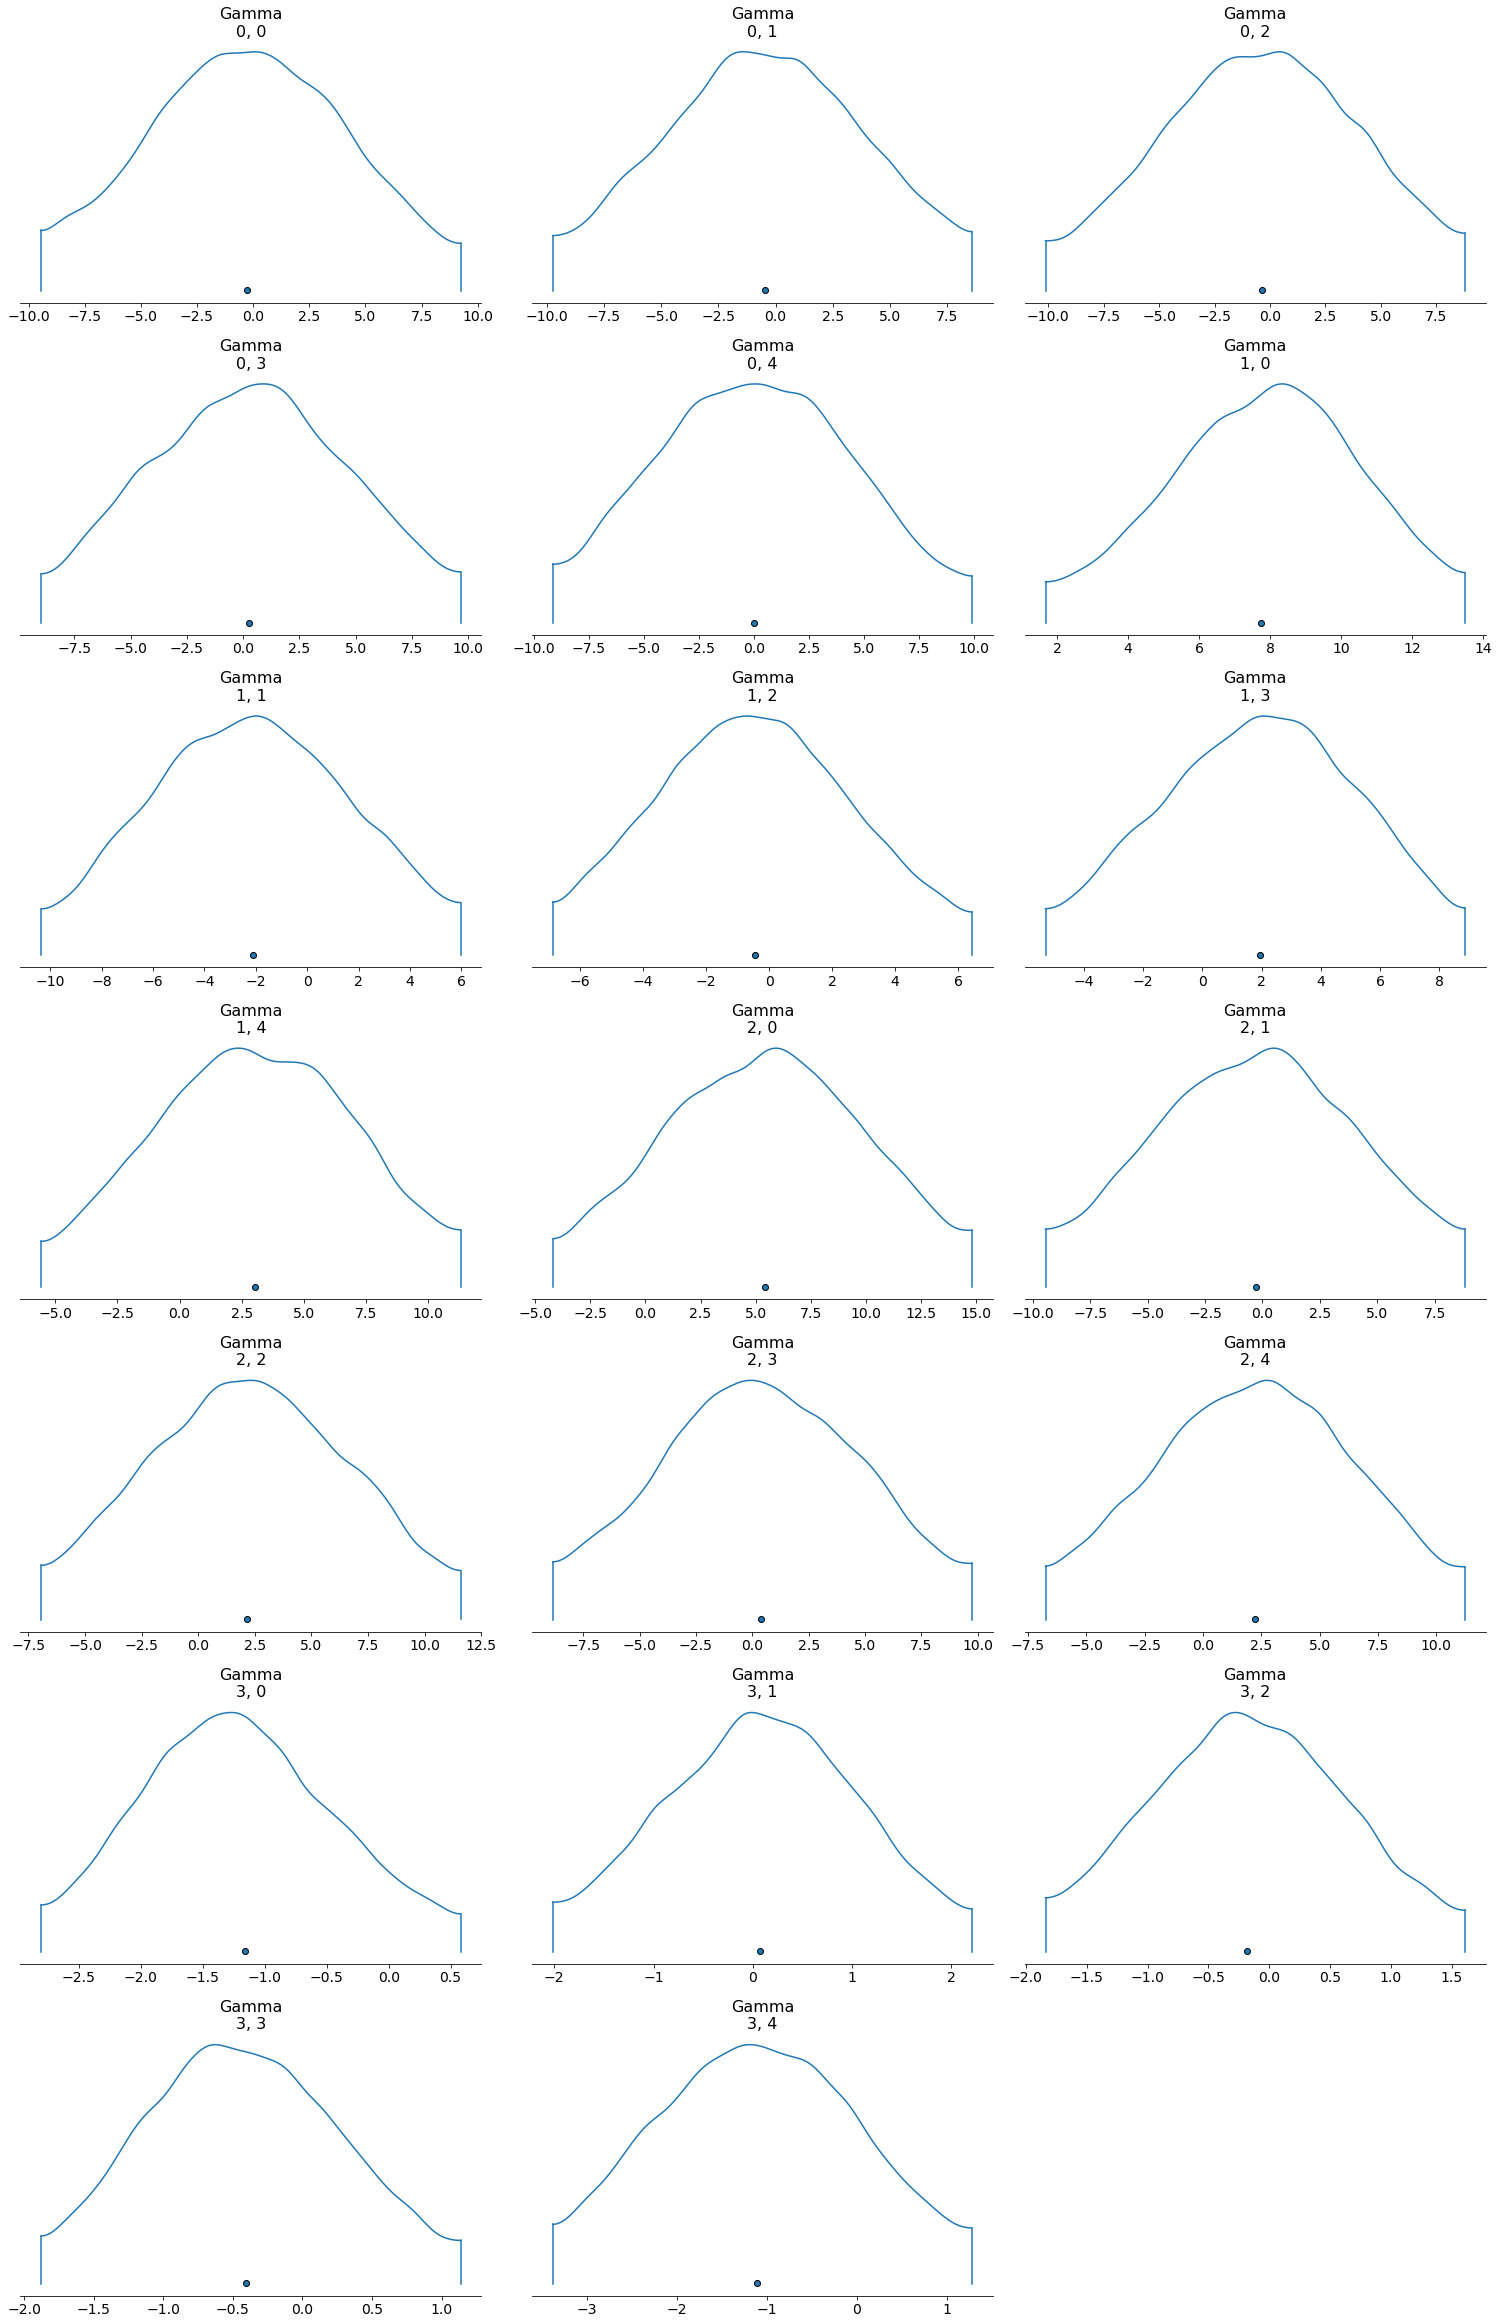

In [10]:
az_data = az.from_pystan(posterior = nonCenter_fit)
az.plot_density(az_data,var_names=["Gamma"])

INFO:numba.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA67892D30>],
      dtype=object)

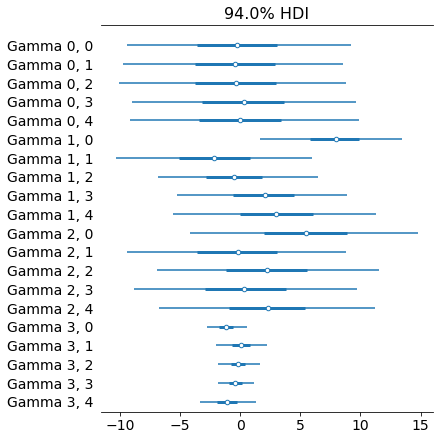

In [11]:
az.plot_forest(az_data, kind='forestplot',var_names=['Gamma'], combined = True)

<font size="4">Beta (Lower-level covariates)</font>

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (45), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA72B65F60>,
      dtype=object)

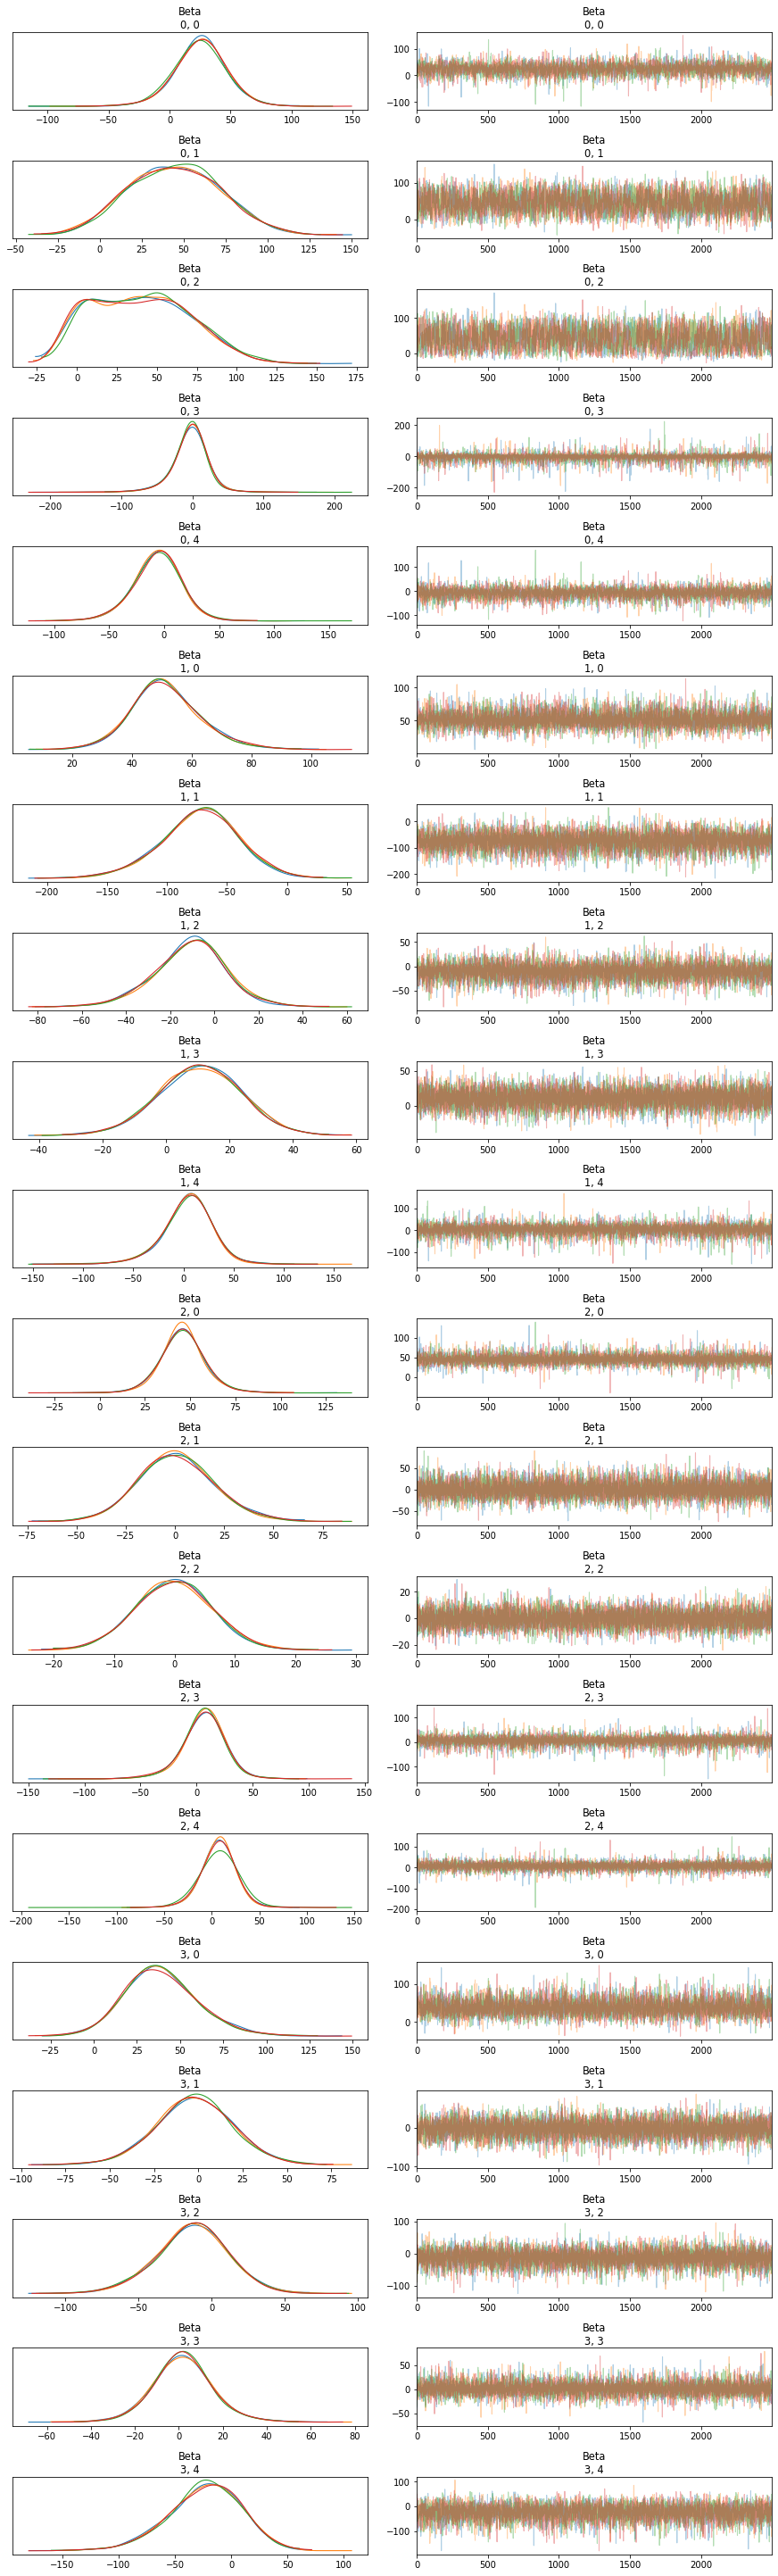

In [12]:
az.plot_trace(nonCenter_fit,var_names=["Beta"])

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\densityplot.py:215: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (45) in plot_density, generating only 40 plots
  UserWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA72E6B630>,
      dtype=object)

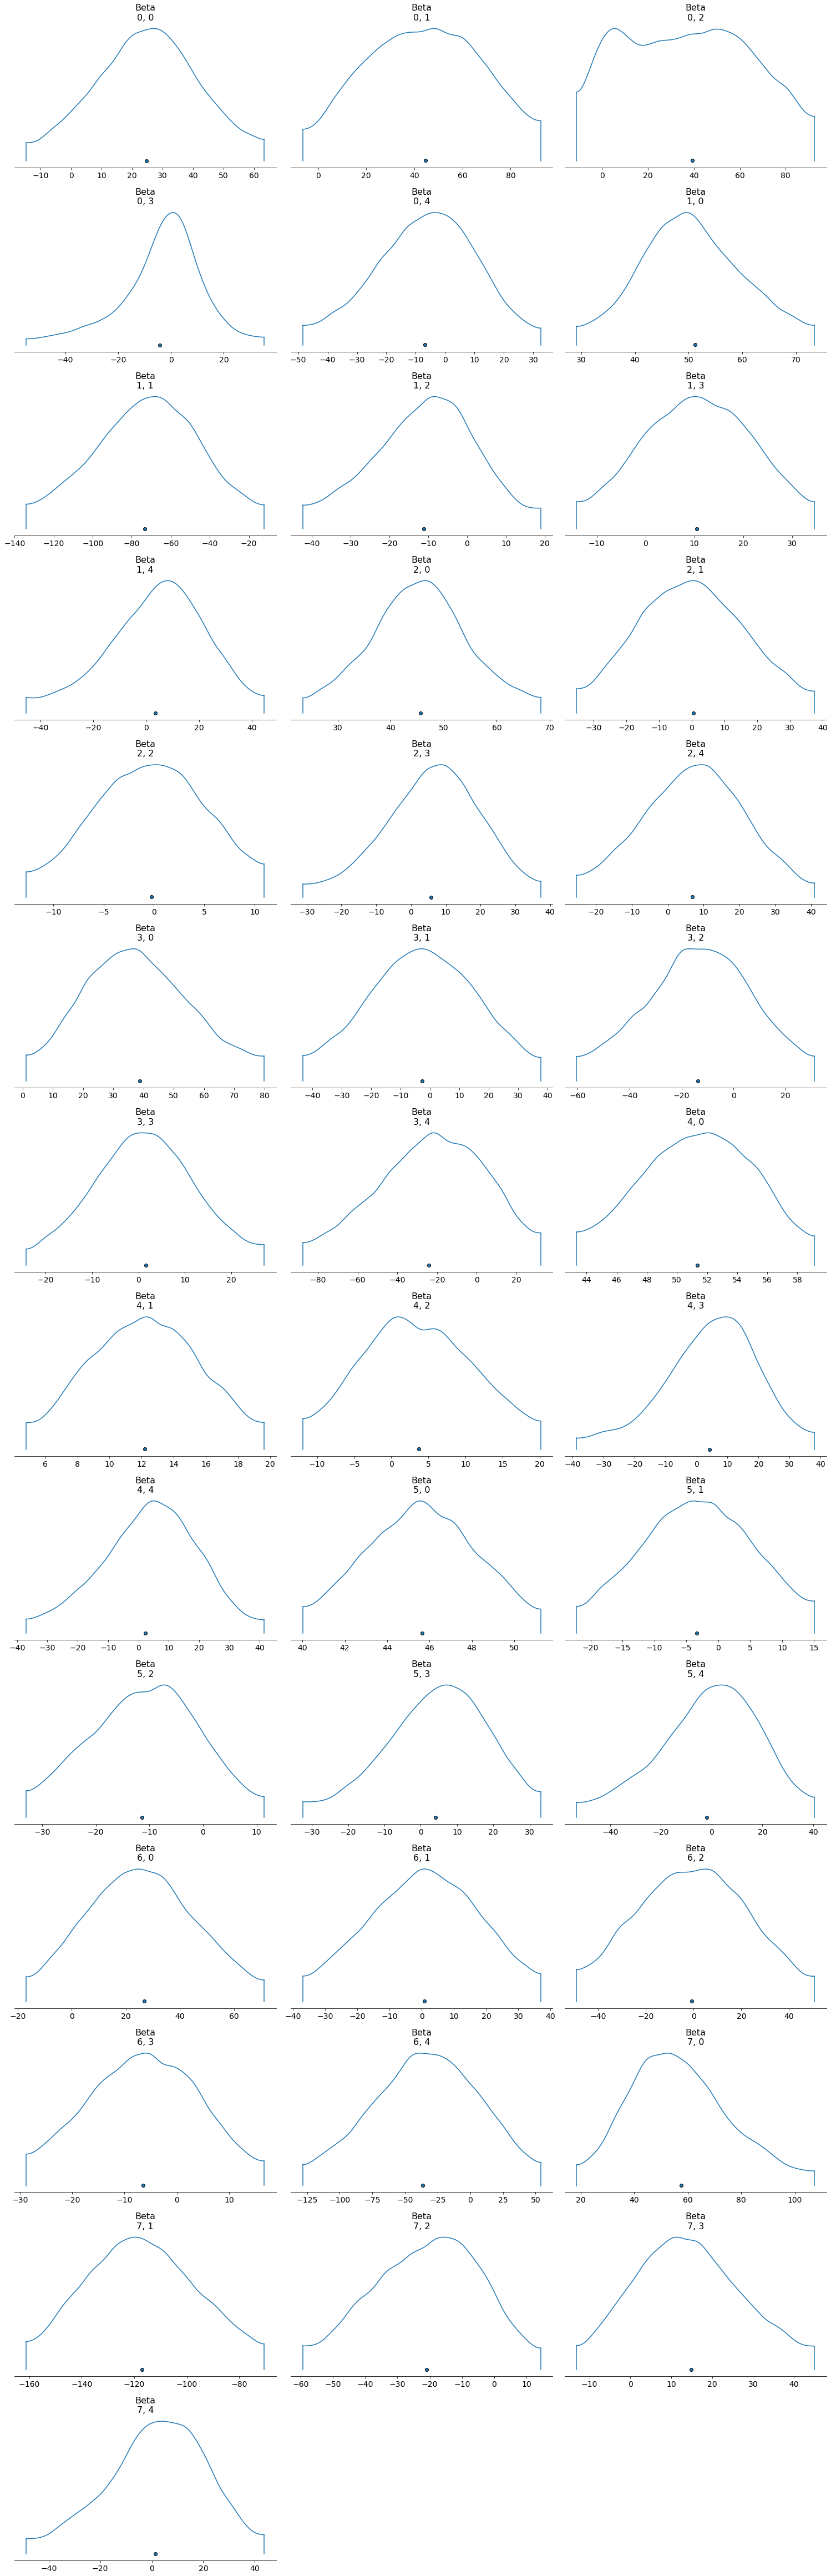

In [13]:
az_data = az.from_pystan(posterior = nonCenter_fit)
az.plot_density(az_data,var_names=["Beta"])

INFO:numba.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6BD7AEB8>],
      dtype=object)

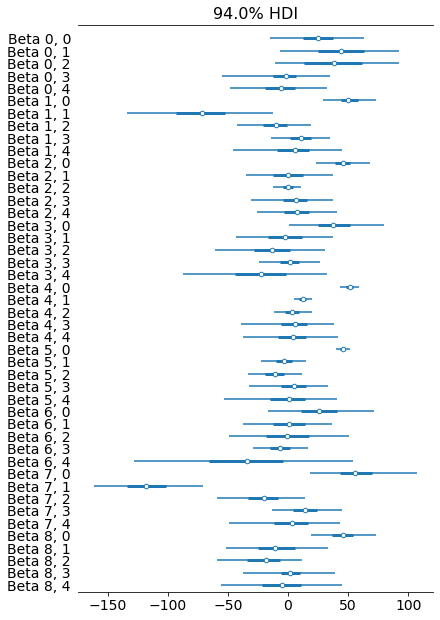

In [14]:
az.plot_forest(az_data, kind='forestplot',var_names=['Beta'], combined = True)

<font size="4">Omega (Correlation between lower-level covariates)</font>

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA7A41ACC0>,
      dtype=object)

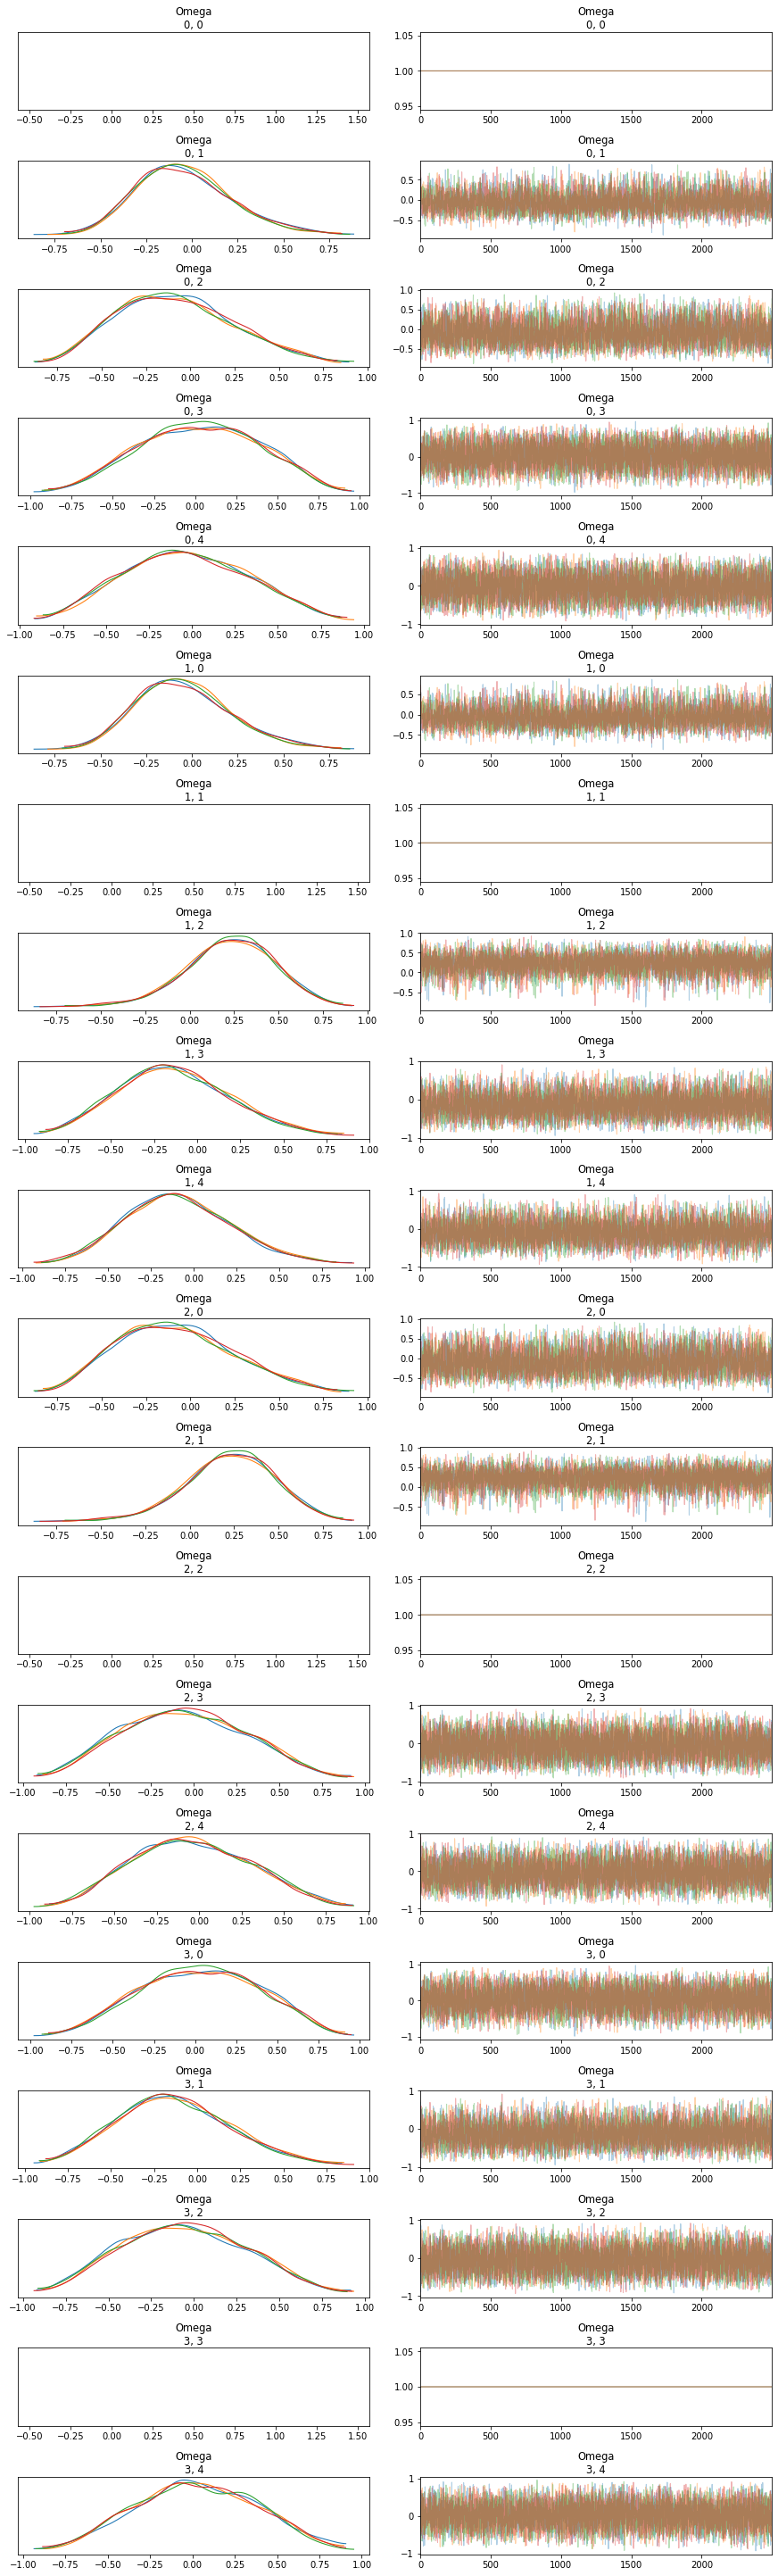

In [15]:
az.plot_trace(nonCenter_fit,var_names=["Omega"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6C0589B0>,
      dtype=object)

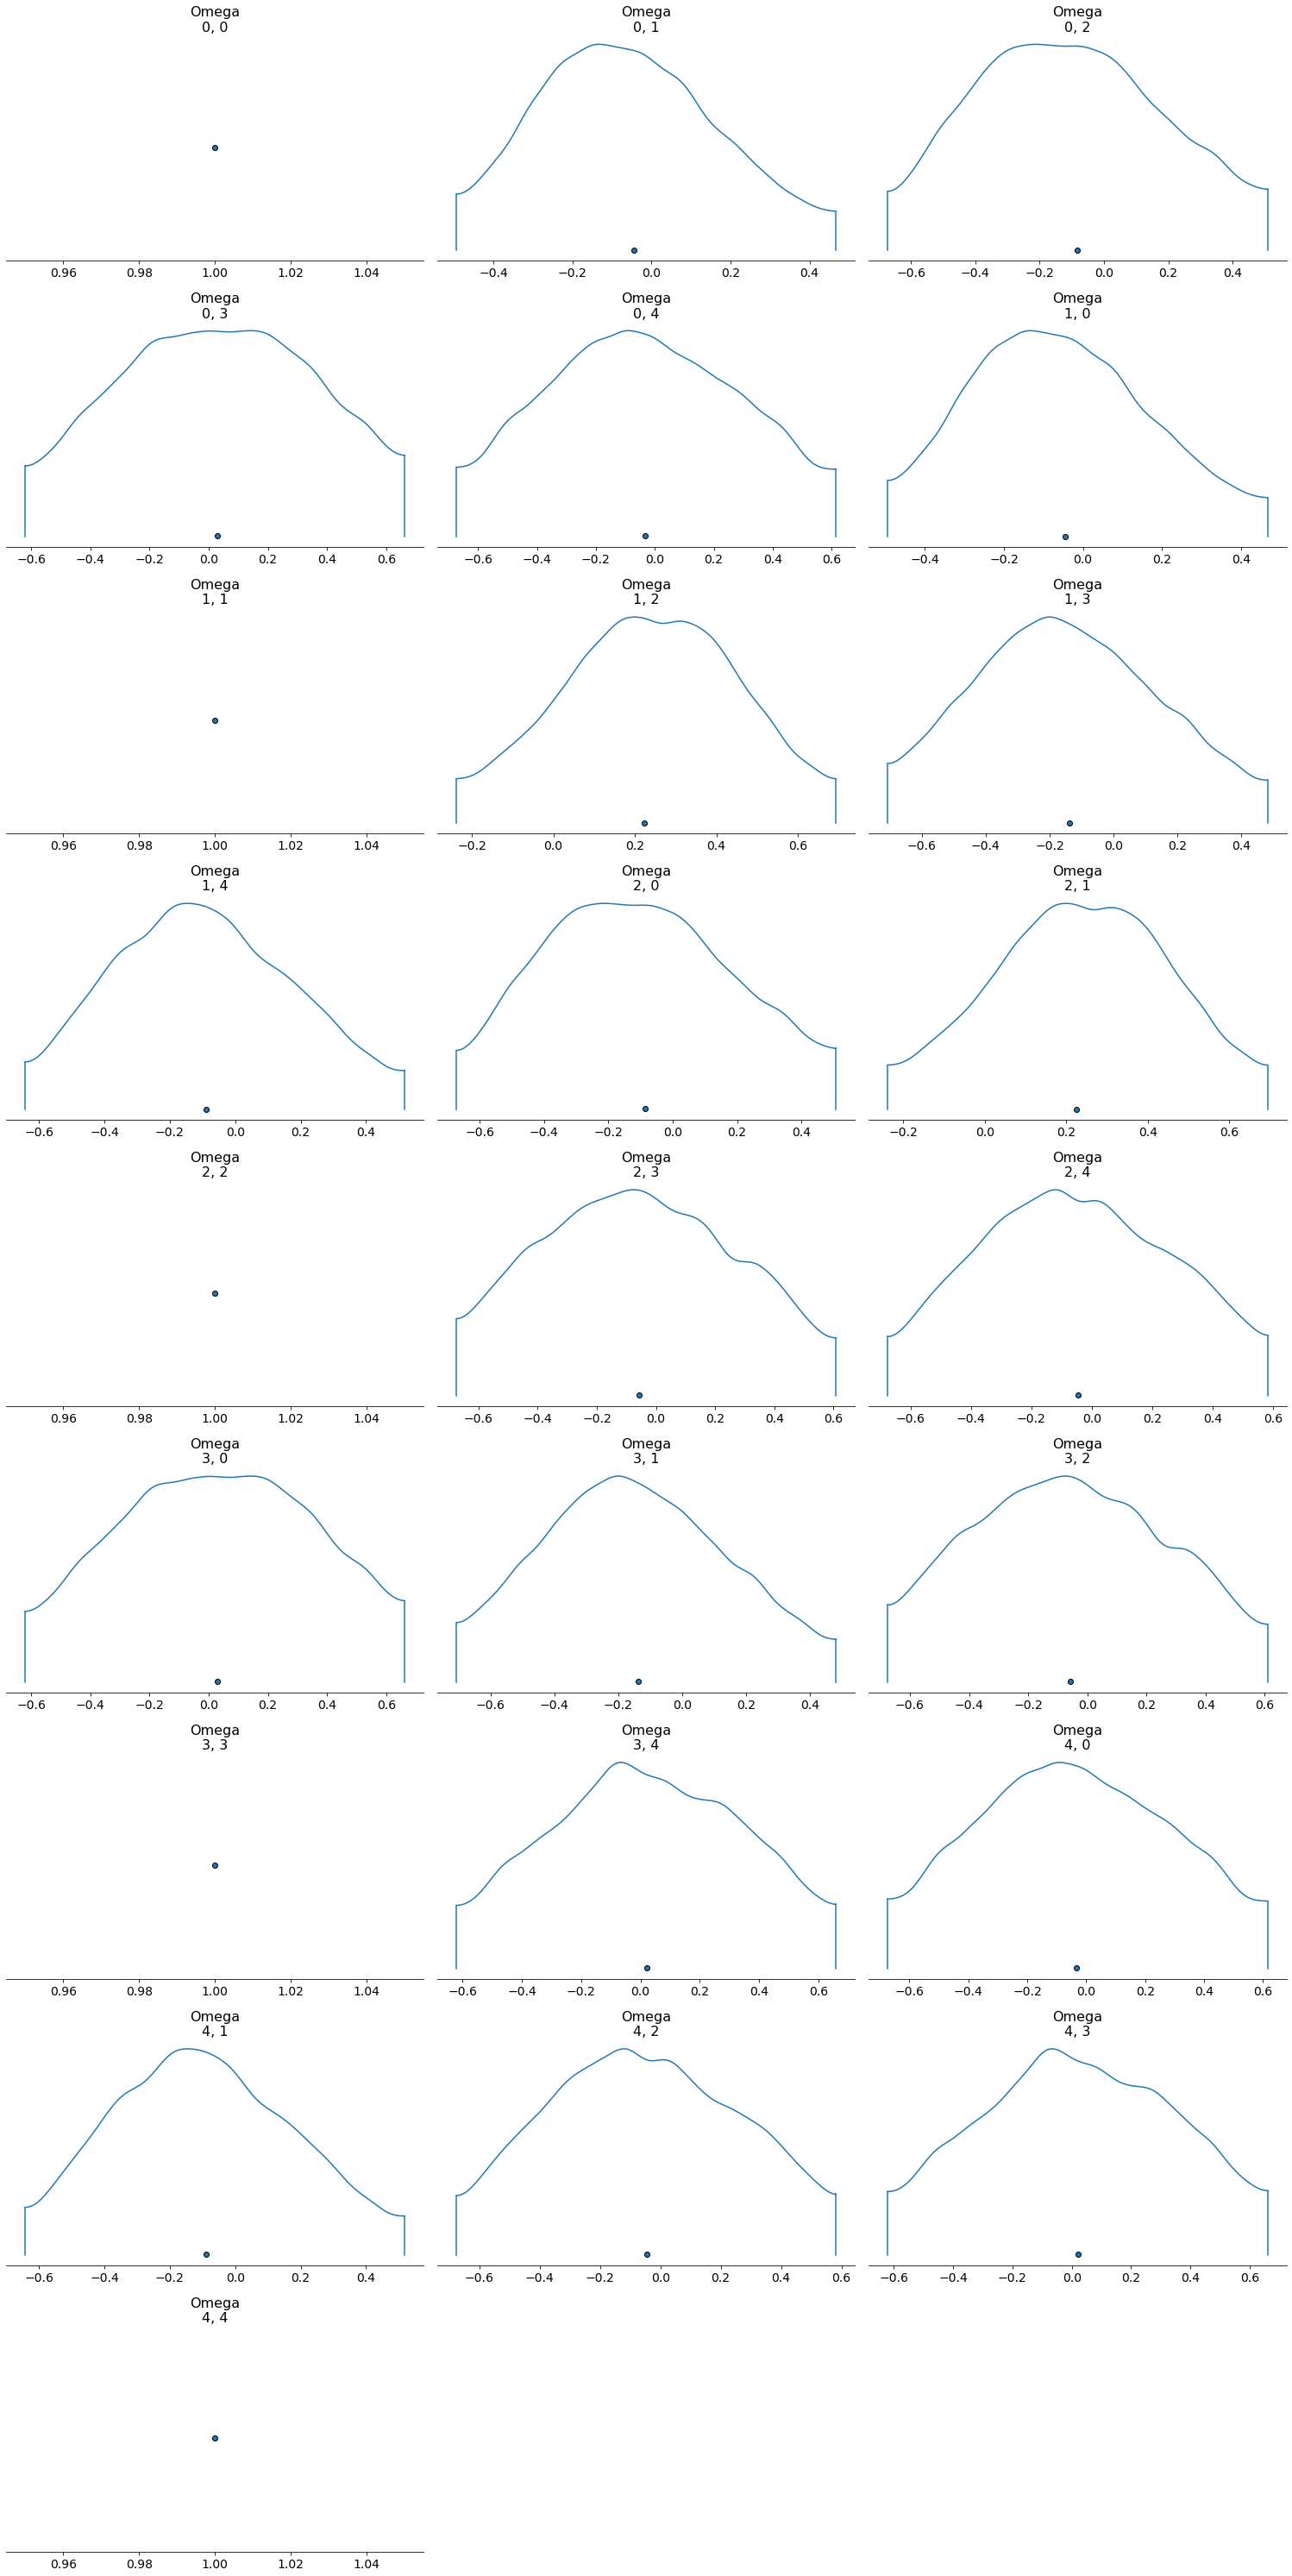

In [16]:
az_data = az.from_pystan(posterior = nonCenter_fit)
az.plot_density(az_data,var_names=["Omega"])

INFO:numba.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA06B58470>],
      dtype=object)

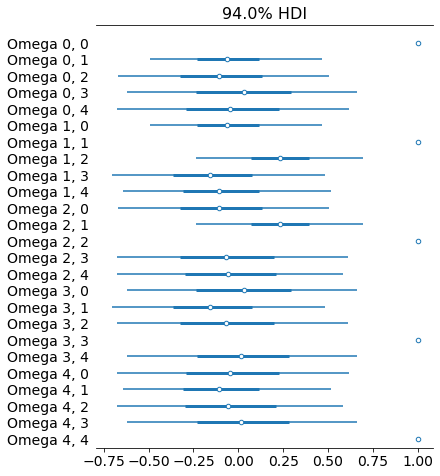

In [17]:
az.plot_forest(az_data, kind='forestplot',var_names=['Omega'], combined = True)

<font size="4">Tau (Scale parameter of the covariance decomposition in the upper-level model)</font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA05DC1630>,
      dtype=object)

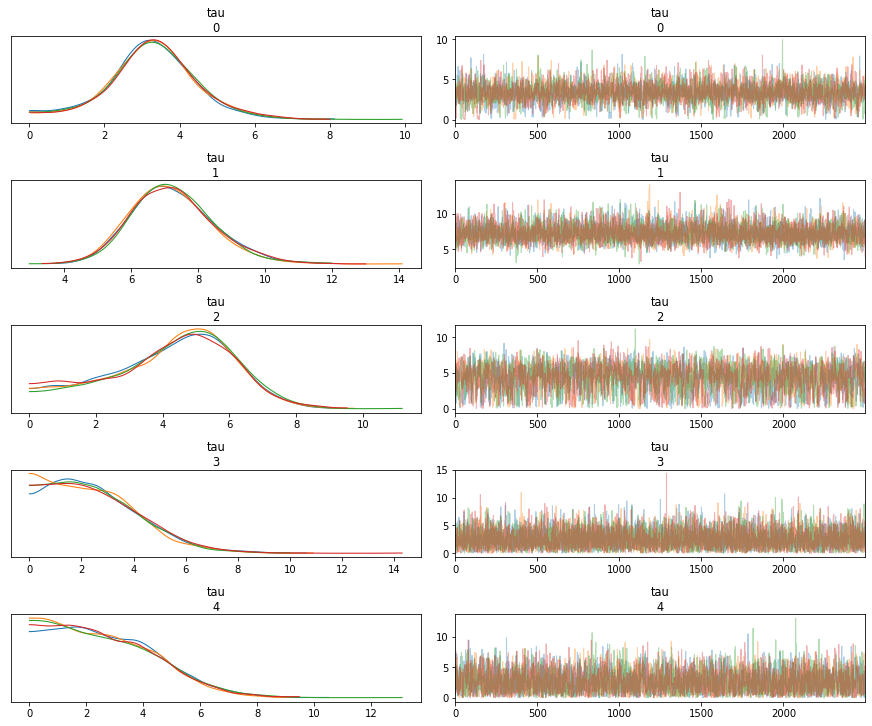

In [18]:
az.plot_trace(nonCenter_fit,var_names=["tau"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA061787B8>,
      dtype=object)

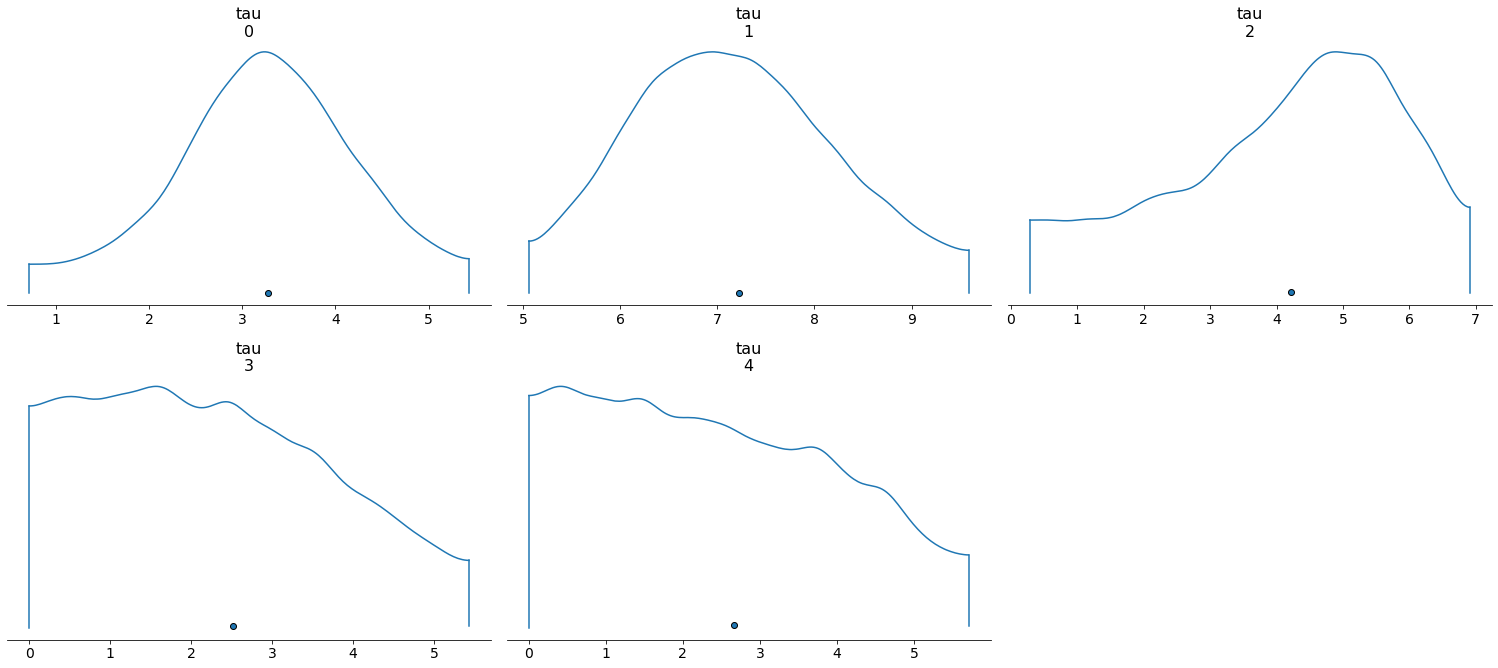

In [19]:
az_data = az.from_pystan(posterior = nonCenter_fit)
az.plot_density(az_data,var_names=["tau"])

INFO:numba.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA0685A2E8>],
      dtype=object)

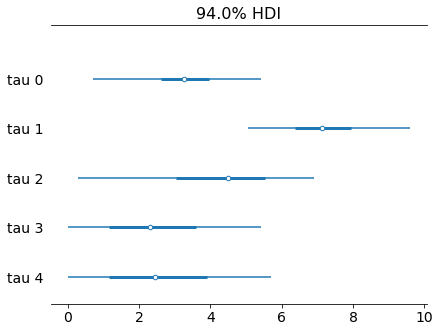

In [20]:
az.plot_forest(az_data, kind='forestplot',var_names=['tau'], combined = True)

<font size="4">Sigma (Variance of the lower-level model)</font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA0862C4A8>,
      dtype=object)

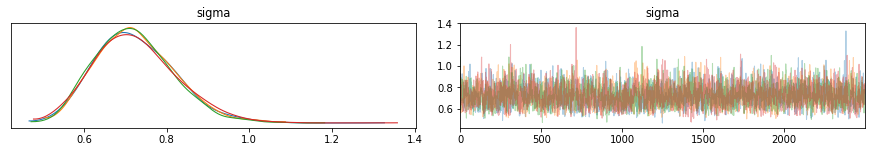

In [21]:
az.plot_trace(nonCenter_fit,var_names=["sigma"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA09AF3EF0>],
      dtype=object)

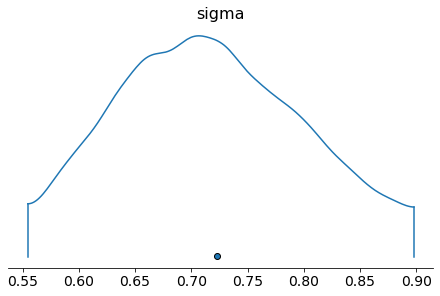

In [22]:
az_data = az.from_pystan(posterior = nonCenter_fit)
az.plot_density(az_data,var_names=["sigma"])

INFO:numba.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA0A5EE438>],
      dtype=object)

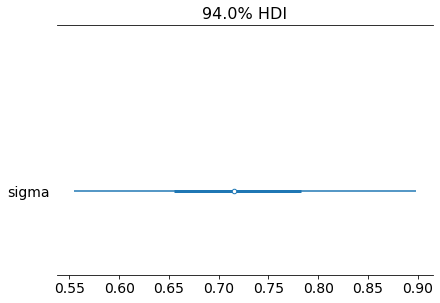

In [23]:
az.plot_forest(az_data, kind='forestplot',var_names=['sigma'], combined = True)

## Diagnostic

In [24]:
pystan.check_hmc_diagnostics(nonCenter_fit) 

{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}